**Figures and manuscript**

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data

In [2]:
cols_of_interest = ['input file name', 'correct diagnosis', 'gpt diagnosis', 'Score (0-5)', 'Rank', 'Score (Peter)', 'Score (Justin)', 'Score (Daniel)', 'Range']

fpath_narrative = 'data/Table 1. ChatGPT4 Diagnosis - text without discussion - txt_cases_results.tsv'
narrative = pd.read_csv(fpath_narrative, sep='\t', usecols=cols_of_interest)
narrative['Src'] = 'nar'
narrative.head(2)

,input file name,correct diagnosis,gpt diagnosis,Score (0-5),Rank,Score (Peter),Score (Justin),Score (Daniel),Range,Src
0,PMID_33471980-case.txt,"Pregnancy-associated myocardial infarction, pr...",Most Likely Diagnosis: Peripartum cardiomyopat...,4.0,2.0,4.0,4.0,4,0,nar
1,PMID_33497551-case.txt,Mycobacterium tuberculosis meningitis,Most Likely Diagnosis: Paraneoplastic limbic e...,5.0,9.0,5.0,5.0,5,0,nar


In [3]:
fpath_signs_symptoms = 'data/Table 2. ChatGPT4 Diagnosis - only age_sex_signs_symptoms - phenopacket_based_queries_results.tsv'
signs_symptoms = pd.read_csv(fpath_signs_symptoms, sep='\t', usecols=cols_of_interest)
signs_symptoms['Src'] = 'ss'
signs_symptoms.head(2)

,input file name,correct diagnosis,gpt diagnosis,Score (0-5),Rank,Score (Peter),Score (Justin),Score (Daniel),Range,Src
0,PMID_33471980-phenopacket-based_query.txt,"Pregnancy-associated myocardial infarction, pr...",Most likely diagnosis: Peripartum cardiomyop...,3.0,1.0,3.0,3.0,3.0,0,ss
1,PMID_33497551-phenopacket-based_query.txt,Mycobacterium tuberculosis meningitis,The following diagnostic test was ordered: Hem...,3.0,-1.0,3.0,3.0,2.0,1,ss


In [5]:
cols = ['input file name', 'Src', 'Score (0-5)', 'Rank']
df = pd.concat([narrative[cols], signs_symptoms[cols]]).sort_index().rename(columns={'Score (0-5)':'Score'})
df

,input file name,Src,Score,Rank
0,PMID_33471980-case.txt,nar,4.0,2.0
0,PMID_33471980-phenopacket-based_query.txt,ss,3.0,1.0
1,PMID_33497551-case.txt,nar,5.0,9.0
1,PMID_33497551-phenopacket-based_query.txt,ss,3.0,-1.0
2,PMID_33503346-phenopacket-based_query.txt,ss,0.0,-1.0
...,...,...,...,...
75,PMID_36477035-phenopacket-based_query.txt,ss,0.0,-1.0
76,PMID_36516093-phenopacket-based_query.txt,ss,0.0,-1.0
77,PMID_36546630-phenopacket-based_query.txt,ss,2.0,15.0
78,PMID_36577103-phenopacket-based_query.txt,ss,0.0,-1.0


Skip the cases where the score is N/A

In [6]:
print(df.loc[df.Score.isna()])
df = df.loc[~df.Score.isna()]

           input file name  Src  Score  Rank
4   PMID_33596360-case.txt  nar    NaN   NaN
79                     NaN   ss    NaN   NaN


Convert to `str`s

In [7]:
df = df.astype({'Score': int, 'Rank': int})

In [8]:
df[df['Src']=='nar'].shape

(74, 4)

In [17]:
df

,input file name,Src,Score,Rank
0,PMID_33471980-case.txt,nar,4,2
0,PMID_33471980-phenopacket-based_query.txt,ss,3,1
1,PMID_33497551-case.txt,nar,5,9
1,PMID_33497551-phenopacket-based_query.txt,ss,3,-1
2,PMID_33503346-phenopacket-based_query.txt,ss,0,-1
...,...,...,...,...
74,PMID_36577103-case.txt,nar,0,-1
75,PMID_36477035-phenopacket-based_query.txt,ss,0,-1
76,PMID_36516093-phenopacket-based_query.txt,ss,0,-1
77,PMID_36546630-phenopacket-based_query.txt,ss,2,15


In [22]:
grouped = df.groupby('Src')

# Define a function to calculate the fraction meeting your condition
def fraction_condition(group):
    condition_met = ((group['Score'] == 5) & (group['Rank'] == 1)).sum()
    total_rows = len(group)
    return condition_met / total_rows

# Apply the function to each group and calculate the fraction
fractions = grouped.apply(fraction_condition) * 100
fractions

Src
nar    17.567568
ss      3.797468
dtype: float64

# Plot histogram of scores

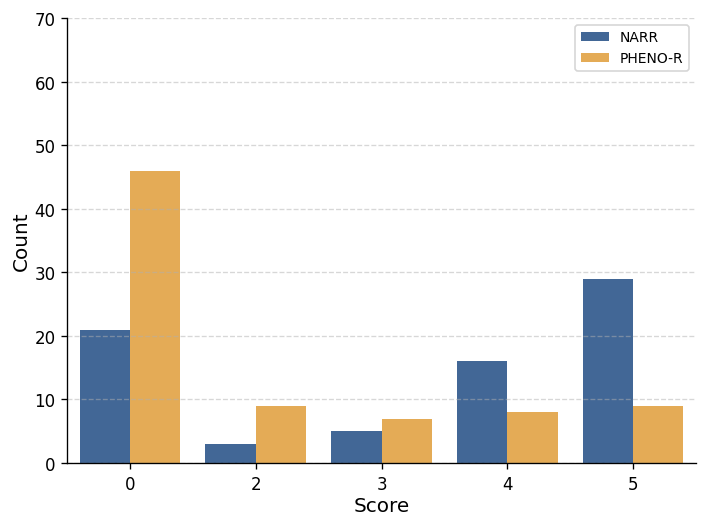

In [9]:
fig, ax = plt.subplots(figsize=(6,4.5), dpi=120)

data = df.astype({'Score': str}).groupby(['Src', 'Score']).size()
data.name='Count'
data = data.reset_index()

sns.barplot(data=data, x='Score', y='Count', hue='Src', 
            palette=['#3465a4', '#fcaf3e'],# c.orange],
            ax=ax)
ax.grid(axis='y')
ax.set(ylim=(0, 70))
ax.legend_.set(title=None)
ax.legend_.get_texts()[0].set(text='NARR')
ax.legend_.get_texts()[1].set(text='PHENO-R')
fig.tight_layout()
fig.savefig('Fig2A.png')

# Plot histogram of the ranks of the correct diagnoses

In [24]:
ranks = df.loc[df.Score >= 4, ['Src', 'Rank']]
rank_bins = [0, 1, 2, 3, 4, 9, 100]
rank_labels = ['1', '2', '3', '4', '5-9', '≥10']

ranks['RankLabel'] = pd.cut(ranks.Rank, bins=rank_bins, labels=rank_labels)
ranks.head(2)

,Src,Rank,RankLabel
0,nar,2,2
1,nar,9,5-9


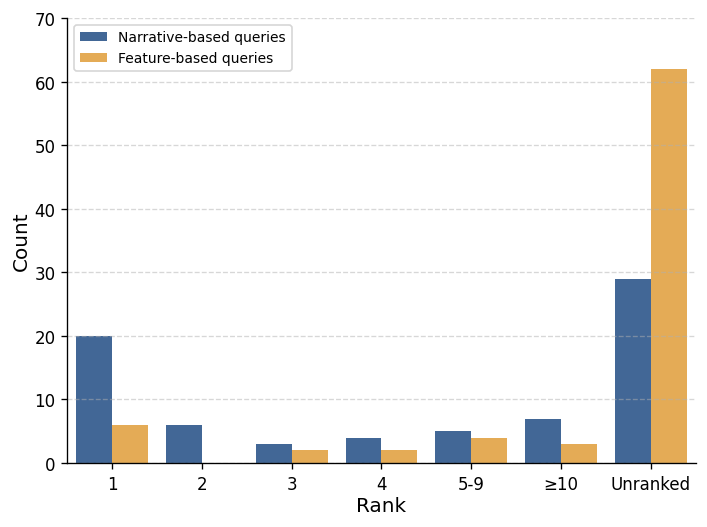

In [25]:
fig, ax = plt.subplots(figsize=(6,4.5), dpi=120)

data = ranks.groupby(['Src', 'RankLabel']).size()
data.name = 'Count'
unranked = df.loc[df.Score <4, ['Src', 'Rank']].groupby('Src').size()
data.loc['ss', 'Unranked'] = unranked.loc['ss']
data.loc['nar', 'Unranked'] = unranked.loc['nar']
data = data.reset_index()

sns.barplot(data=data, x='RankLabel', y='Count', hue='Src', 
            palette=['#3465a4', '#fcaf3e'],# c.orange],
            ax=ax)
ax.grid(axis='y')
ax.set(xlabel='Rank', ylim=(0, 70))
ax.legend_.set(title=None)
ax.legend_.get_texts()[0].set(text='Narrative-based queries')
ax.legend_.get_texts()[1].set(text='Feature-based queries')
fig.tight_layout()
fig.savefig('Fig2B.png')

# The entire figure

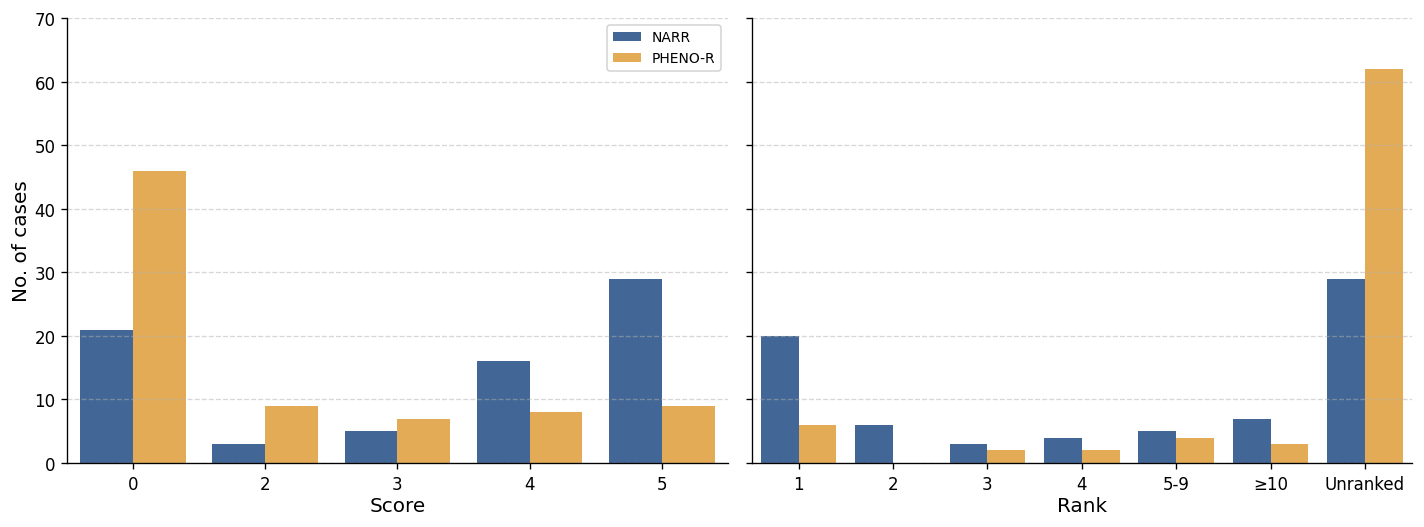

In [27]:
fig, (l, r) = plt.subplots(1, 2, figsize=(12, 4.5), dpi=120, sharey=True)

# (A)
data = df.astype({'Score': str}).groupby(['Src', 'Score']).size()
data.name = 'No. of cases'
data = data.reset_index()

sns.barplot(data=data, x='Score', y='No. of cases', hue='Src', 
            palette=['#3465a4', '#fcaf3e'],
            ax=l)
l.grid(axis='y')
l.set(ylim=(0, 70))
l.legend_.set(title=None)
l.legend_.get_texts()[0].set(text='NARR')
l.legend_.get_texts()[1].set(text='PHENO-R')

# (B)
data = ranks.groupby(['Src', 'RankLabel']).size()
data.name = 'No. of cases'
unranked = df.loc[df.Score <4, ['Src', 'Rank']].groupby('Src').size()
data.loc['ss', 'Unranked'] = unranked.loc['ss']
data.loc['nar', 'Unranked'] = unranked.loc['nar']
data = data.reset_index()

sns.barplot(data=data, x='RankLabel', y='No. of cases', hue='Src', 
            palette=['#3465a4', '#fcaf3e'],# c.orange],
            ax=r)
r.grid(axis='y')
r.set(xlabel='Rank', ylabel=None)
r.legend_.set(visible=False)

fig.tight_layout()
fig.savefig('Figure2.raw.svg')

Postprocess in Inkscape to increase horizontal space between the panels and to add panel labels.

Done

In [29]:
!open 'Figure2.raw.svg'